# Music Genre Classification
## 8. Batch Audio Features Extraction using Librosa 

<img src='music.jpg' width = 600>

<div class="alert alert-info"> <b> In this notebook we will generate audio features for all the files.</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 02-Mar-2022 | V1

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy
import librosa
import librosa.display
import IPython
from pathlib import Path

In [2]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
now = datetime.datetime.now()
print(now)

2022-03-02 11:54:51.718493


In [4]:
def CountFiles(mypath):
    print("Total of files in", mypath, "=", sum(len(files) for _, _, files in os.walk(mypath)),'\n')
    for root, _, files in os.walk(mypath):
        print(root, ":", len(files), "files")

## 1. Directory to use to generate audio features for each file

In [9]:
AUDIOFILES_DIR = "audiofiles/genres"

In [10]:
CountFiles(AUDIOFILES_DIR)

Total of files in audiofiles/genres = 1012 

audiofiles/genres : 12 files
audiofiles/genres/blues : 100 files
audiofiles/genres/classical : 100 files
audiofiles/genres/country : 100 files
audiofiles/genres/disco : 100 files
audiofiles/genres/hiphop : 100 files
audiofiles/genres/jazz : 100 files
audiofiles/genres/metal : 100 files
audiofiles/genres/pop : 100 files
audiofiles/genres/reggae : 100 files
audiofiles/genres/rock : 100 files


In [20]:
!rm audiofiles/Genres/*.mf

## 2. Directory to save the results

In [11]:
FEATURES_DIR = 'features'

if Path(FEATURES_DIR).is_dir() == True:
    os.rmdir(FEATURES_DIR)
    print("Deleting previous directory...")
    os.mkdir(FEATURES_DIR)
    print("Directory is created")
    
if Path(FEATURES_DIR).is_dir() == False:
    os.mkdir(FEATURES_DIR)
    print("Directory is created")

CountFiles(FEATURES_DIR)

Directory is created
Total of files in features = 0 

features : 0 files


## 3. Function to extract audio features

In [12]:
def audiofeaturesextraction(audio):
    
    print(datetime.datetime.now(), "Generating audio features extraction from:", audio)
    
    # Getting some file infromations
    basename = os.path.basename(audio)
    basenamewithoutext = os.path.splitext(basename)[0]
    extension = os.path.splitext(audiofilelocation)[1][1:]
    fullfilename = audiofilelocation
    dirsname = os.path.dirname(audio)
    category = dirsname.split("/",1)[1]

    basename_df = pd.DataFrame({'filename': [basename]})
    basenamewithoutext_df = pd.DataFrame({'basename': [basenamewithoutext]})
    ext_df = pd.DataFrame({'extension': [extension]})
    dirsname_df = pd.DataFrame({'dirsname': [dirsname]})
    fullfilename_df = pd.DataFrame({'fullfilename': [fullfilename]})
    category_df = pd.DataFrame({'category': [category]})
    
    # dataframe with filename and directory information
    filename_df = pd.concat([fullfilename_df, dirsname_df, category_df, basename_df, 
                             basenamewithoutext_df, ext_df], axis=1)
    
    # Loading sound file
    y, sr = librosa.load(audio)
    
    # Harmonic & percussive
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    
    # Chroma
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    
    chroma_df = pd.DataFrame()

    for i in range(0,12):
        chroma_df['chroma_mean_' + str(i)] = chroma_mean[i]

    for i in range(0,12):
        chroma_df['chroma_std_' + str(i)] = chroma_mean[i]
    
    chroma_df.loc[0] = np.concatenate((chroma_mean,chroma_std), axis=0)
    
    # MFCCS
    mfccs = librosa.feature.mfcc(y = y_harmonic, sr = sr, n_mfcc = 13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    coeffs = np.arange(0,13)

    mfccs_df = pd.DataFrame()
    
    for i in range(0,13):
        mfccs_df['mfccs_mean_'+str(i)] = mfccs_mean[i]

    for i in range(0,13):
        mfccs_df['mfccs_std_'+str(i)] = mfccs_mean[i]
        
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis=0)
    
    # Cent
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis=1)[0]

    # Contrast
    contrast = librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
    contrast_mean = np.mean(contrast,axis=1)
    contrast_std = np.std(contrast,axis=1)
    conts = np.arange(0,7)
    contrast_df = pd.DataFrame()

    # rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff,axis=1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent_mean','cent_std','cent_skew']

    for i in range(0,7):
        collist.append('contrast_mean_' + str(i))

    for i in range(0,7):
        collist.append('contrast_std_' + str(i))
        
    collist = collist + ['rolloff_mean','rolloff_std','rolloff_skew']
    
    for c in collist:
        spectral_df[c] = 0
    
    data=np.concatenate(([cent_mean, cent_std, cent_skew], contrast_mean, contrast_std,
                         [rolloff_mean, rolloff_std, rolloff_std]), axis=0)
    spectral_df.loc[0] = data
    
    # zrate
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate,axis=1)[0]
    zrate_df = pd.DataFrame()
    zrate_df['zrate_mean'] = 0
    zrate_df['zrate_std'] = 0
    zrate_df['zrate_skew'] = 0
    zrate_df.loc[0] = [zrate_mean,zrate_std,zrate_skew]

    # beat
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo

    # Additional informations
    sr_df = pd.DataFrame({'sampling_rate': [sr]})
    totalsamples = np.size(y)
    duration = totalsamples / sr
    totalsamples_df = pd.DataFrame({'total_samples': [totalsamples]})
    duration_df = pd.DataFrame({'duration': [duration]})

    # Saving audiofeatures to a dataframe
    audiofeatures_df = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis=1)
    
    # Saving all results into a single dataframe
    filesaudio_df = pd.concat([filename_df, sr_df, totalsamples_df, duration_df, audiofeatures_df], axis=1)
    
    # Export to CSV for each audio file
    outputfile = FEATURES_DIR + '/' + basenamewithoutext + '_features.csv'
    filesaudio_df.to_csv(outputfile)

## 4. Let's run the function to extract audio features for each file

In [21]:
start = datetime.datetime.now()

print(start, 'Audio Features extraction...\n')

for root, dirs, files in os.walk(AUDIOFILES_DIR):
    for audiofile in files:
        audiofilelocation = root + '/' + audiofile
        audiofeaturesextraction(audiofilelocation)

end = datetime.datetime.now()
print('\n', end, 'End of job. Processing time:', end - start)

2022-03-02 11:59:00.289520 Audio Features extraction...

2022-03-02 11:59:00.380121 Generating audio features extraction from: audiofiles/genres/blues/blues.00000.wav
2022-03-02 11:59:04.229422 Generating audio features extraction from: audiofiles/genres/blues/blues.00001.wav
2022-03-02 11:59:07.304688 Generating audio features extraction from: audiofiles/genres/blues/blues.00002.wav
2022-03-02 11:59:10.366430 Generating audio features extraction from: audiofiles/genres/blues/blues.00003.wav
2022-03-02 11:59:13.307432 Generating audio features extraction from: audiofiles/genres/blues/blues.00004.wav
2022-03-02 11:59:16.204391 Generating audio features extraction from: audiofiles/genres/blues/blues.00005.wav
2022-03-02 11:59:19.155529 Generating audio features extraction from: audiofiles/genres/blues/blues.00006.wav
2022-03-02 11:59:21.986014 Generating audio features extraction from: audiofiles/genres/blues/blues.00007.wav
2022-03-02 11:59:24.873176 Generating audio features extraction

2022-03-02 12:02:39.990332 Generating audio features extraction from: audiofiles/genres/blues/blues.00074.wav
2022-03-02 12:02:42.989184 Generating audio features extraction from: audiofiles/genres/blues/blues.00075.wav
2022-03-02 12:02:45.788813 Generating audio features extraction from: audiofiles/genres/blues/blues.00076.wav
2022-03-02 12:02:48.745586 Generating audio features extraction from: audiofiles/genres/blues/blues.00077.wav
2022-03-02 12:02:51.598758 Generating audio features extraction from: audiofiles/genres/blues/blues.00078.wav
2022-03-02 12:02:54.574351 Generating audio features extraction from: audiofiles/genres/blues/blues.00079.wav
2022-03-02 12:02:57.471353 Generating audio features extraction from: audiofiles/genres/blues/blues.00080.wav
2022-03-02 12:03:00.395426 Generating audio features extraction from: audiofiles/genres/blues/blues.00081.wav
2022-03-02 12:03:03.440709 Generating audio features extraction from: audiofiles/genres/blues/blues.00082.wav
2022-03-02

2022-03-02 12:06:15.160247 Generating audio features extraction from: audiofiles/genres/classical/classical.00046.wav
2022-03-02 12:06:18.151926 Generating audio features extraction from: audiofiles/genres/classical/classical.00047.wav
2022-03-02 12:06:21.235050 Generating audio features extraction from: audiofiles/genres/classical/classical.00048.wav
2022-03-02 12:06:24.158235 Generating audio features extraction from: audiofiles/genres/classical/classical.00049.wav
2022-03-02 12:06:27.088072 Generating audio features extraction from: audiofiles/genres/classical/classical.00050.wav
2022-03-02 12:06:30.167350 Generating audio features extraction from: audiofiles/genres/classical/classical.00051.wav
2022-03-02 12:06:33.102129 Generating audio features extraction from: audiofiles/genres/classical/classical.00052.wav
2022-03-02 12:06:36.081184 Generating audio features extraction from: audiofiles/genres/classical/classical.00053.wav
2022-03-02 12:06:38.871394 Generating audio features ext

2022-03-02 12:09:42.599316 Generating audio features extraction from: audiofiles/genres/country/country.00016.wav
2022-03-02 12:09:45.824481 Generating audio features extraction from: audiofiles/genres/country/country.00017.wav
2022-03-02 12:09:48.737783 Generating audio features extraction from: audiofiles/genres/country/country.00018.wav
2022-03-02 12:09:51.938628 Generating audio features extraction from: audiofiles/genres/country/country.00019.wav
2022-03-02 12:09:54.967240 Generating audio features extraction from: audiofiles/genres/country/country.00020.wav
2022-03-02 12:09:57.667295 Generating audio features extraction from: audiofiles/genres/country/country.00021.wav
2022-03-02 12:10:00.313775 Generating audio features extraction from: audiofiles/genres/country/country.00022.wav
2022-03-02 12:10:03.001901 Generating audio features extraction from: audiofiles/genres/country/country.00023.wav
2022-03-02 12:10:06.030420 Generating audio features extraction from: audiofiles/genres/

2022-03-02 12:13:07.163463 Generating audio features extraction from: audiofiles/genres/country/country.00088.wav
2022-03-02 12:13:09.762745 Generating audio features extraction from: audiofiles/genres/country/country.00089.wav
2022-03-02 12:13:12.383538 Generating audio features extraction from: audiofiles/genres/country/country.00090.wav
2022-03-02 12:13:15.375901 Generating audio features extraction from: audiofiles/genres/country/country.00091.wav
2022-03-02 12:13:18.237174 Generating audio features extraction from: audiofiles/genres/country/country.00092.wav
2022-03-02 12:13:21.031419 Generating audio features extraction from: audiofiles/genres/country/country.00093.wav
2022-03-02 12:13:23.842862 Generating audio features extraction from: audiofiles/genres/country/country.00094.wav
2022-03-02 12:13:26.707262 Generating audio features extraction from: audiofiles/genres/country/country.00095.wav
2022-03-02 12:13:29.587403 Generating audio features extraction from: audiofiles/genres/

2022-03-02 12:16:35.345504 Generating audio features extraction from: audiofiles/genres/disco/disco.00063.wav
2022-03-02 12:16:38.236831 Generating audio features extraction from: audiofiles/genres/disco/disco.00064.wav
2022-03-02 12:16:41.314776 Generating audio features extraction from: audiofiles/genres/disco/disco.00065.wav
2022-03-02 12:16:44.139888 Generating audio features extraction from: audiofiles/genres/disco/disco.00066.wav
2022-03-02 12:16:46.900637 Generating audio features extraction from: audiofiles/genres/disco/disco.00067.wav
2022-03-02 12:16:49.942653 Generating audio features extraction from: audiofiles/genres/disco/disco.00068.wav
2022-03-02 12:16:52.916905 Generating audio features extraction from: audiofiles/genres/disco/disco.00069.wav
2022-03-02 12:16:55.863324 Generating audio features extraction from: audiofiles/genres/disco/disco.00070.wav
2022-03-02 12:16:59.062633 Generating audio features extraction from: audiofiles/genres/disco/disco.00071.wav
2022-03-02

2022-03-02 12:20:04.706213 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00037.wav
2022-03-02 12:20:07.874966 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00038.wav
2022-03-02 12:20:10.836933 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00039.wav
2022-03-02 12:20:13.693942 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00040.wav
2022-03-02 12:20:16.581823 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00041.wav
2022-03-02 12:20:19.441957 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00042.wav
2022-03-02 12:20:22.456248 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00043.wav
2022-03-02 12:20:25.316795 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00044.wav
2022-03-02 12:20:28.115713 Generating audio features extraction from: audiofiles/genres/hiphop/hiphop.00

2022-03-02 12:23:35.381510 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00011.wav
2022-03-02 12:23:38.178329 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00012.wav
2022-03-02 12:23:41.013559 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00013.wav
2022-03-02 12:23:43.833942 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00014.wav
2022-03-02 12:23:46.434944 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00015.wav
2022-03-02 12:23:49.014709 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00016.wav
2022-03-02 12:23:51.859911 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00017.wav
2022-03-02 12:23:54.695401 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00018.wav
2022-03-02 12:23:57.527190 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00019.wav
2022-03-02 12:24:00.462951 G

2022-03-02 12:27:09.371719 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00087.wav
2022-03-02 12:27:12.109636 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00088.wav
2022-03-02 12:27:14.899632 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00089.wav
2022-03-02 12:27:17.728811 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00090.wav
2022-03-02 12:27:20.585887 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00091.wav
2022-03-02 12:27:23.394854 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00092.wav
2022-03-02 12:27:26.221364 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00093.wav
2022-03-02 12:27:29.111324 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00094.wav
2022-03-02 12:27:31.947633 Generating audio features extraction from: audiofiles/genres/jazz/jazz.00095.wav
2022-03-02 12:27:34.854755 G

2022-03-02 12:30:39.811044 Generating audio features extraction from: audiofiles/genres/metal/metal.00062.wav
2022-03-02 12:30:42.598636 Generating audio features extraction from: audiofiles/genres/metal/metal.00063.wav
2022-03-02 12:30:45.482916 Generating audio features extraction from: audiofiles/genres/metal/metal.00064.wav
2022-03-02 12:30:48.355830 Generating audio features extraction from: audiofiles/genres/metal/metal.00065.wav
2022-03-02 12:30:51.298277 Generating audio features extraction from: audiofiles/genres/metal/metal.00066.wav
2022-03-02 12:30:54.040285 Generating audio features extraction from: audiofiles/genres/metal/metal.00067.wav
2022-03-02 12:30:56.888261 Generating audio features extraction from: audiofiles/genres/metal/metal.00068.wav
2022-03-02 12:30:59.688767 Generating audio features extraction from: audiofiles/genres/metal/metal.00069.wav
2022-03-02 12:31:02.490904 Generating audio features extraction from: audiofiles/genres/metal/metal.00070.wav
2022-03-02

2022-03-02 12:34:14.256057 Generating audio features extraction from: audiofiles/genres/pop/pop.00038.wav
2022-03-02 12:34:17.028761 Generating audio features extraction from: audiofiles/genres/pop/pop.00039.wav
2022-03-02 12:34:19.802670 Generating audio features extraction from: audiofiles/genres/pop/pop.00040.wav
2022-03-02 12:34:22.585610 Generating audio features extraction from: audiofiles/genres/pop/pop.00041.wav
2022-03-02 12:34:25.377412 Generating audio features extraction from: audiofiles/genres/pop/pop.00042.wav
2022-03-02 12:34:28.267165 Generating audio features extraction from: audiofiles/genres/pop/pop.00043.wav
2022-03-02 12:34:31.040935 Generating audio features extraction from: audiofiles/genres/pop/pop.00044.wav
2022-03-02 12:34:33.833289 Generating audio features extraction from: audiofiles/genres/pop/pop.00045.wav
2022-03-02 12:34:36.643503 Generating audio features extraction from: audiofiles/genres/pop/pop.00046.wav
2022-03-02 12:34:39.417559 Generating audio fe

2022-03-02 12:37:55.950921 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00015.wav
2022-03-02 12:37:58.859249 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00016.wav
2022-03-02 12:38:01.867180 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00017.wav
2022-03-02 12:38:04.825080 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00018.wav
2022-03-02 12:38:07.709209 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00019.wav
2022-03-02 12:38:11.777834 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00020.wav
2022-03-02 12:38:14.565152 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00021.wav
2022-03-02 12:38:17.425866 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00022.wav
2022-03-02 12:38:20.213355 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00

2022-03-02 12:41:25.690756 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00089.wav
2022-03-02 12:41:28.484647 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00090.wav
2022-03-02 12:41:31.329033 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00091.wav
2022-03-02 12:41:34.273401 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00092.wav
2022-03-02 12:41:37.141979 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00093.wav
2022-03-02 12:41:39.916350 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00094.wav
2022-03-02 12:41:42.684519 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00095.wav
2022-03-02 12:41:45.504707 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00096.wav
2022-03-02 12:41:48.350219 Generating audio features extraction from: audiofiles/genres/reggae/reggae.00

2022-03-02 12:45:02.856005 Generating audio features extraction from: audiofiles/genres/rock/rock.00065.wav
2022-03-02 12:45:05.655288 Generating audio features extraction from: audiofiles/genres/rock/rock.00066.wav
2022-03-02 12:45:08.609488 Generating audio features extraction from: audiofiles/genres/rock/rock.00067.wav
2022-03-02 12:45:11.393440 Generating audio features extraction from: audiofiles/genres/rock/rock.00068.wav
2022-03-02 12:45:14.296554 Generating audio features extraction from: audiofiles/genres/rock/rock.00069.wav
2022-03-02 12:45:17.358700 Generating audio features extraction from: audiofiles/genres/rock/rock.00070.wav
2022-03-02 12:45:20.270893 Generating audio features extraction from: audiofiles/genres/rock/rock.00071.wav
2022-03-02 12:45:23.067544 Generating audio features extraction from: audiofiles/genres/rock/rock.00072.wav
2022-03-02 12:45:25.926624 Generating audio features extraction from: audiofiles/genres/rock/rock.00073.wav
2022-03-02 12:45:28.961486 G

## 5. Results

In [22]:
CountFiles(FEATURES_DIR)

Total of files in features = 1000 

features : 1000 files


In [23]:
os.chdir(FEATURES_DIR)

filepaths = [f for f in os.listdir() if f.endswith('.csv')] # Taking all the CSV files into a single dataframe
audiofeaturesdf = pd.concat(map(pd.read_csv, filepaths))

del audiofeaturesdf['Unnamed: 0'] # Cleaning the df
audiofeaturesdf = audiofeaturesdf.reset_index(drop=True) # Clean index

os.chdir('..')

In [24]:
audiofeaturesdf.head(10)

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,audiofiles/genres/blues/blues.00000.wav,audiofiles/genres/blues,genres/blues,blues.00000.wav,blues.00000,wav,22050,661794,30.013333,0.268007,...,4.049205,2.225948,2.163108,3805.839606,949.476395,949.476395,0.070435,0.024249,0.890262,123.046875
1,audiofiles/genres/blues/blues.00001.wav,audiofiles/genres/blues,genres/blues,blues.00001.wav,blues.00001,wav,22050,661794,30.013333,0.245332,...,4.701318,3.809115,5.004282,3550.522098,1725.657379,1725.657379,0.044427,0.030633,1.921759,67.999589
2,audiofiles/genres/blues/blues.00002.wav,audiofiles/genres/blues,genres/blues,blues.00002.wav,blues.00002,wav,22050,661794,30.013333,0.044975,...,4.225142,3.051108,3.191152,3042.260232,885.457204,885.457204,0.064752,0.025841,1.677929,161.499023
3,audiofiles/genres/blues/blues.00003.wav,audiofiles/genres/blues,genres/blues,blues.00003.wav,blues.00003,wav,22050,661794,30.013333,0.149017,...,3.839645,2.869564,3.706476,2184.745799,1221.963322,1221.963322,0.024861,0.015907,0.834285,117.453835
4,audiofiles/genres/blues/blues.00004.wav,audiofiles/genres/blues,genres/blues,blues.00004.wav,blues.00004,wav,22050,661794,30.013333,0.149890,...,4.448131,4.207953,4.630709,3579.757627,1254.184130,1254.184130,0.085567,0.033966,2.602187,135.999178
5,audiofiles/genres/blues/blues.00005.wav,audiofiles/genres/blues,genres/blues,blues.00005.wav,blues.00005,wav,22050,661794,30.013333,0.174925,...,4.917749,4.723192,6.588556,3481.517592,1809.541367,1809.541367,0.073991,0.057311,3.374352,69.837416
6,audiofiles/genres/blues/blues.00006.wav,audiofiles/genres/blues,genres/blues,blues.00006.wav,blues.00006,wav,22050,661794,30.013333,0.303592,...,5.417220,4.878502,7.041656,2795.610963,1273.358561,1273.358561,0.056864,0.034149,1.520404,198.768029
7,audiofiles/genres/blues/blues.00007.wav,audiofiles/genres/blues,genres/blues,blues.00007.wav,blues.00007,wav,22050,661794,30.013333,0.133723,...,4.814811,3.389852,5.065702,2954.836760,1276.373759,1276.373759,0.047277,0.031320,2.423022,95.703125
8,audiofiles/genres/blues/blues.00008.wav,audiofiles/genres/blues,genres/blues,blues.00008.wav,blues.00008,wav,22050,661794,30.013333,0.369538,...,4.085412,2.340272,1.822251,3782.316288,1123.795795,1123.795795,0.047112,0.023864,0.704822,83.354335
9,audiofiles/genres/blues/blues.00009.wav,audiofiles/genres/blues,genres/blues,blues.00009.wav,blues.00009,wav,22050,661794,30.013333,0.214747,...,4.612679,4.875278,4.566951,3943.490565,1169.460660,1169.460660,0.061078,0.020804,1.671922,198.768029


In [25]:
audiofeaturesdf.shape

(1000, 83)

In [26]:
audiofeaturesdf.columns

Index(['fullfilename', 'dirsname', 'category', 'filename', 'basename',
       'extension', 'sampling_rate', 'total_samples', 'duration',
       'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
  

In [27]:
audiofeaturesdf.describe()

,sampling_rate,total_samples,duration,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,22050.0,662030.846000,30.024075,0.231559,0.198893,0.234094,0.199882,0.232737,0.220368,0.209292,...,3.933489,3.266728,2.825249,4571.549296,1264.656237,1264.656237,0.078118,0.034847,1.037309,122.438671
std,0.0,1784.073992,0.080910,0.103748,0.095626,0.109291,0.101576,0.103861,0.105675,0.098628,...,0.920305,1.041975,1.208417,1574.791614,495.211918,495.211918,0.033649,0.017099,0.804584,28.447295
min,22050.0,660000.000000,29.931973,0.007150,0.004073,0.007804,0.001019,0.004138,0.016006,0.002986,...,1.823899,1.443102,1.067505,749.140636,121.186297,121.186297,0.012361,0.006922,-1.246983,39.151278
25%,22050.0,661504.000000,30.000181,0.159347,0.134059,0.160818,0.126797,0.159656,0.141822,0.136752,...,3.346964,2.539014,1.945535,3380.069642,879.051311,879.051311,0.052625,0.023489,0.496886,103.359375
50%,22050.0,661794.000000,30.013333,0.226326,0.190277,0.221298,0.190267,0.222951,0.214307,0.198610,...,3.853673,3.102064,2.503909,4658.524473,1214.954591,1214.954591,0.074203,0.031341,0.919751,117.453835
75%,22050.0,661794.000000,30.013333,0.300308,0.254667,0.298683,0.261214,0.297451,0.283598,0.269606,...,4.494174,3.811818,3.365301,5533.810460,1598.517423,1598.517423,0.098226,0.041115,1.402686,135.999178
max,22050.0,675808.000000,30.648889,0.609475,0.697539,0.735442,0.604490,0.640573,0.630532,0.644477,...,8.709325,8.604912,8.560648,8677.672688,2942.940788,2942.940788,0.291536,0.145699,5.006928,258.398438


In [28]:
audiofeaturesdf['category'].value_counts()

genres/reggae       100
genres/metal        100
genres/country      100
genres/rock         100
genres/pop          100
genres/blues        100
genres/disco        100
genres/classical    100
genres/hiphop       100
genres/jazz         100
Name: category, dtype: int64

Text(0, 0.5, 'Number of files')

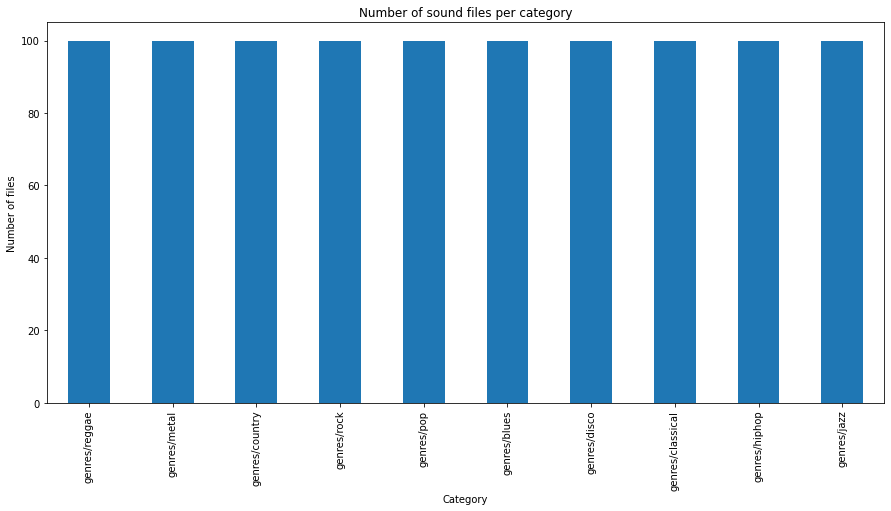

In [29]:
%matplotlib inline
ax = audiofeaturesdf['category'].value_counts().plot(kind='bar', figsize=(15,7), 
                                                     title="Number of sound files per category")
ax.set_xlabel("Category")
ax.set_ylabel("Number of files")

## 6. EDA

In [30]:
# Let's create a sample for the EDA
pctsample = 0.1
dfsample = audiofeaturesdf.sample(frac = pctsample)

In [31]:
dfsample.head()

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
47,audiofiles/genres/blues/blues.00047.wav,audiofiles/genres/blues,genres/blues,blues.00047.wav,blues.00047,wav,22050,661794,30.013333,0.152607,...,3.321260,2.744926,2.017418,4848.826029,762.389329,762.389329,0.056885,0.022488,1.332839,143.554688
233,audiofiles/genres/country/country.00033.wav,audiofiles/genres/country,genres/country,country.00033.wav,country.00033,wav,22050,661794,30.013333,0.096764,...,4.540482,4.312907,2.614787,4914.691318,1264.235891,1264.235891,0.099629,0.046131,0.727443,92.285156
295,audiofiles/genres/country/country.00095.wav,audiofiles/genres/country,genres/country,country.00095.wav,country.00095,wav,22050,661794,30.013333,0.247289,...,5.001527,3.497352,2.842812,3220.920869,1177.794472,1177.794472,0.048667,0.025768,1.371976,89.102909
459,audiofiles/genres/hiphop/hiphop.00059.wav,audiofiles/genres/hiphop,genres/hiphop,hiphop.00059.wav,hiphop.00059,wav,22050,661794,30.013333,0.329705,...,3.686253,2.909741,1.561423,4218.975674,1737.379037,1737.379037,0.031486,0.026671,2.422163,184.570312
949,audiofiles/genres/rock/rock.00049.wav,audiofiles/genres/rock,genres/rock,rock.00049.wav,rock.00049,wav,22050,661794,30.013333,0.033736,...,4.342471,2.898706,2.073660,4495.809731,2578.718754,2578.718754,0.071963,0.037995,1.678240,112.347147


## 7. Export features to CSV and Excel files

In [32]:
EXPORTFEATURES_DIR = 'featuresresults'

if Path(EXPORTFEATURES_DIR).is_dir() == False:
    os.mkdir(EXPORTFEATURES_DIR)
    print("Directory is created")

csv_output = EXPORTFEATURES_DIR + '/musicaudiofeatures.csv' # CSV filename to create
excel_output = EXPORTFEATURES_DIR + '/musicaudiofeatures.xls' # Excel filename to create

Directory is created


In [33]:
audiofeaturesdf.to_csv(csv_output)

In [34]:
audiofeaturesdf.to_excel(excel_output)

In [35]:
CountFiles(EXPORTFEATURES_DIR)

Total of files in featuresresults = 2 

featuresresults : 2 files


In [36]:
from IPython.display import FileLink

CSVLINK = FileLink(path = csv_output)
print("Click to download the file:")
CSVLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Sound/MusicGenreClassification/featuresresults/musicaudiofeatures.csv

In [37]:
XLSLINK = FileLink(path = excel_output)
print("Click to download the file:")
XLSLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Sound/MusicGenreClassification/featuresresults/musicaudiofeatures.xls

> End of this notebook. You can use the next notebook.